In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [ ]:
import pickle
from typing import Tuple

import diffrax
import equinox as eqx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import Array, PyTree, Scalar
from tqdm.auto import tqdm as tq

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments.examples as examples
import optimal_control.nn as nn
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
)
from optimal_control.solvers.base import build_control

In [ ]:
a4_inches = (8.3, 11.7)
plot_full_width = a4_inches[0]
plot_half_width = a4_inches[0] / 2
plot_third_width = a4_inches[0] / 3
plot_quarter_width = a4_inches[0] / 4

result_base_dir = "../thesis-results/fibrosis"
plot_style = "seaborn-paper"

plot_shrink_factor = 0.9

plt.style.use(plot_style)

In [ ]:
def save(path: str, **kwargs):
    with open(result_base_dir + path, mode="wb") as f:
        pickle.dump(kwargs, f)


def load(path: str):
    with open(result_base_dir + path, mode="rb") as f:
        return pickle.load(f).values()

# Find optimal PI settings

## Run experiment

In [ ]:
environment = FibrosisEnvironment()
state = environment.init()

constraint_chain = constraints.ConstraintChain(
    transformations=[
        constraints.NonNegativeConstantIntegralConstraint(
            target=jnp.asarray([0.01, 0.01])
        )
    ]
)

"""
control = controls.InterpolationCurveControl(
    nn.InterpolationCurve(
        method="linear",
        nodes=(jax.random.uniform(jax.random.PRNGKey(1234), (16, 2)) + 1) * 0.01,
        t_start=0.0 - 1,
        t_end=200.0 + 1,
        steps=16,
        channels=2,
    )
)

constrained_control = build_control(control, constraint_chain)[0]
"""

constrained_control = controls.LambdaControl(lambda _: jnp.full(2, 0.01))

In [ ]:
@jax.jit
def with_coeff(
    pcoeff: Scalar, icoeff: Scalar, rtol: Scalar, atol: Scalar, dtmax: Scalar
) -> int:
    solution: diffrax.Solution = environment.integrate(
        constrained_control,
        state,
        None,
        throw=False,
        max_steps=10000,
        stepsize_controller=diffrax.PIDController(
            rtol=rtol, atol=atol, pcoeff=pcoeff, icoeff=icoeff, dtmax=dtmax
        ),
    )
    return solution.stats, solution.result

In [ ]:
pcoeff = jnp.linspace(0.0, 1.0, 64)
icoeff = jnp.linspace(0.0, 1.0, 64)

pcoeff, icoeff = jnp.meshgrid(pcoeff, icoeff)

In [ ]:
coeff_stats = []
coeff_results = []
for p, i in tq(
    zip(pcoeff.flatten(), icoeff.flatten()), total=pcoeff.flatten().shape[0]
):
    stats, adaptive_results = with_coeff(p, i, 1e-4, 1e-4, 1.0)

    coeff_stats.append(stats)
    coeff_results.append(adaptive_results)

In [ ]:
coeff_nodtmax_stats = []
coeff_nodtmax_results = []
for p, i in tq(
    zip(pcoeff.flatten(), icoeff.flatten()), total=pcoeff.flatten().shape[0]
):
    stats, adaptive_results = with_coeff(p, i, 1e-4, 1e-4, None)

    coeff_nodtmax_stats.append(stats)
    coeff_nodtmax_results.append(adaptive_results)

In [ ]:
coeff_min_idx = np.argmin([stats["num_steps"] for stats in coeff_stats])
coeff_stats[coeff_min_idx], pcoeff.flatten()[coeff_min_idx], icoeff.flatten()[
    coeff_min_idx
]

In [ ]:
atol = jnp.geomspace(1e-1, 1e-8, 64)
rtol = jnp.geomspace(1e-1, 1e-8, 64)

atol, rtol = jnp.meshgrid(atol, rtol)

In [ ]:
tol_stats = []
tol_results = []
for a, r in tq(zip(atol.flatten(), rtol.flatten()), total=atol.flatten().shape[0]):
    stats, adaptive_results = with_coeff(1.0, 1.0, r, a, 1.0)

    tol_stats.append(stats)
    tol_results.append(adaptive_results)

In [ ]:
tol_nodtmax_stats = []
tol_nodtmax_results = []
for a, r in tq(zip(atol.flatten(), rtol.flatten()), total=atol.flatten().shape[0]):
    stats, adaptive_results = with_coeff(1.0, 1.0, r, a, None)

    tol_nodtmax_stats.append(stats)
    tol_nodtmax_results.append(adaptive_results)

In [ ]:
tol_min_idx = np.argmin([stats["num_steps"] for stats in tol_stats])
tol_stats[tol_min_idx], rtol.flatten()[tol_min_idx], atol.flatten()[tol_min_idx]

In [ ]:
save(
    "/pid_callibration/pcoeff_icoeff_sweep.pickle",
    coeff_stats=coeff_stats,
    coeff_results=coeff_results,
)

save(
    "/pid_callibration/atol_rtol_sweep.pickle",
    tol_stats=tol_stats,
    tol_results=tol_results,
)

save(
    "/pid_callibration/pcoeff_icoeff_nodtmax_sweep.pickle",
    coeff_nodtmax_stats=coeff_nodtmax_stats,
    coeff_nodtmax_results=coeff_results,
)

save(
    "/pid_callibration/atol_rtol_nodtmax_sweep.pickle",
    tol_nodtmax_stats=tol_nodtmax_stats,
    tol_nodtmax_results=tol_nodtmax_results,
)

In [ ]:
coeff_stats, coeff_results = load("/pid_callibration/pcoeff_icoeff_sweep.pickle")
tol_stats, tol_results = load("/pid_callibration/atol_rtol_sweep.pickle")

coeff_nodtmax_stats, coeff_nodtmax_results = load(
    "/pid_callibration/pcoeff_icoeff_nodtmax_sweep.pickle"
)
tol_nodtmax_stats, tol_nodtmax_results = load(
    "/pid_callibration/atol_rtol_nodtmax_sweep.pickle"
)

## Plot results

In [ ]:
fudge_factor = 0.8

In [ ]:
def plot_coeff(coeff_stats: dict, fig_path: str):
    plt.figure(figsize=(plot_half_width * fudge_factor, plot_half_width * fudge_factor))

    plt.xlabel("Proportional Coeff.")
    plt.ylabel("Integral Coeff.")

    cmap = matplotlib.colormaps["viridis"]
    cmap.set_bad(color="red")

    plt.imshow(
        np.reshape(
            [
                stats["num_steps"]
                if stats["num_steps"] < stats["max_steps"]
                else np.NaN
                for stats in coeff_stats
            ],
            (64, 64),
        ),
        cmap=cmap,
        norm="log",
        origin="lower",
        interpolation="nearest",
        extent=(
            pcoeff.flatten()[0],
            pcoeff.flatten()[-1],
            icoeff.flatten()[0],
            icoeff.flatten()[-1],
        ),
    )

    cbar = plt.colorbar(label="Num. Integration Steps", fraction=0.04575, pad=0.04)
    plt.scatter([0.99], [0.99], c="white", marker="X")

    plt.savefig(result_base_dir + fig_path + ".png", bbox_inches="tight")
    plt.savefig(result_base_dir + fig_path + ".svg", bbox_inches="tight")

    plt.show()


plot_coeff(coeff_stats, "/pid_callibration/pcoeff_icoeff_sweep")
plot_coeff(coeff_nodtmax_stats, "/pid_callibration/pcoeff_icoeff_nodtmax_sweep")

In [ ]:
def plot_tol(tol_stats: dict, fig_path: str):
    plt.figure(figsize=(plot_half_width * fudge_factor, plot_half_width * fudge_factor))

    plt.xlabel("Absolute Tolerance")
    plt.ylabel("Relative Tolerance")

    cmap = matplotlib.colormaps["viridis"]
    cmap.set_bad(color="red")

    plt.xscale("log")
    plt.yscale("log")

    plt.pcolormesh(
        atol,
        rtol,
        np.reshape(
            [
                stats["num_steps"]
                if stats["num_steps"] < stats["max_steps"]
                else np.NaN
                for stats in tol_stats
            ],
            (64, 64),
        ),
        cmap=cmap,
        norm="log",
    )

    cbar = plt.colorbar(label="Num. Integration Steps", fraction=0.049, pad=0.04)
    plt.scatter([1e-4], [1e-4], c="white", marker="X")

    plt.savefig(result_base_dir + fig_path + ".png", bbox_inches="tight")
    plt.savefig(result_base_dir + fig_path + ".svg", bbox_inches="tight")

    plt.show()


plot_tol(tol_stats, "/pid_callibration/rtol_atol_sweep")
plot_tol(tol_nodtmax_stats, "/pid_callibration/rtol_atol_nodtmax_sweep")

# InterpolationCurve Control

In [ ]:
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
)

environment = FibrosisEnvironment()
environment_state = environment.init()

constraint_chain = constraints.ConstraintChain(
    transformations=[
        constraints.NonNegativeConstantIntegralConstraint(
            # target=jnp.asarray([0.01, 0.01])
            target=jnp.asarray([0.1]),
            constrain_sum=True,
        )
    ]
)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]
    # return -jnp.mean(jnp.log(jnp.clip(solution.ys[..., :2], a_min=1e2)))


control = controls.InterpolationCurveControl(
    nn.InterpolationCurve(
        method="linear",
        # nodes=jax.random.normal(jax.random.PRNGKey(1234), (16, 2)),
        t_start=0.0,
        t_end=200.0,
        steps=201,
        channels=2,
    )
)
solver = solvers.DirectSolver(
    optimizer=optax.adam(learning_rate=1e-2), ignore_nans=False
)

key = jax.random.PRNGKey(1234)

In [ ]:
optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
    num_train_steps=1024,
    environment=environment,
    reward_fn=reward_fn,
    constraint_chain=constraint_chain,
    solver=solver,
    control=control,
    key=key,
    pbar_interval=8,
    integrate_kwargs=dict(
        max_steps=1000,
        throw=True,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0
        ),
    ),
)

In [ ]:
constrained_control = build_control(optimized_control, constraint_chain)[0]

ts = jnp.linspace(-10.0, 210.0, 1024)
ys = jax.vmap(constrained_control)(ts)

plt.figure()
plt.plot(ts, ys)
plt.show()

In [ ]:
ts = jnp.linspace(0.0, 200.0, 1024)

constrained_control = build_control(optimized_control, constraint_chain)[0]
solution = environment.integrate(
    constrained_control, environment.init(), None, saveat=diffrax.SaveAt(ts=ts)
)

cs = jax.vmap(constrained_control)(ts)
ys = solution.ys

plt.figure()
plt.plot(ts, cs)
plt.show()

plt.figure()
plt.yscale("log")
plt.plot(ts, ys[..., :4])
plt.show()

plt.figure()
plt.plot(ts, ys[..., 5])
plt.show()

print(ys[-1, -1])

# Implicit SIREN -> Interpolation Curve

In [ ]:
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
)

key = jax.random.PRNGKey(1234)

environment = FibrosisEnvironment()

constraint_chain = constraints.ConstraintChain(
    transformations=[
        constraints.NonNegativeConstantIntegralConstraint(
            # target=jnp.asarray([0.1, 0.1])
            target=jnp.asarray([0.1]),
            constrain_sum=True,
        )
    ]
)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]
    # return -jnp.mean(jnp.log(jnp.clip(solution.ys[..., :2], a_min=1e2)))


key, subkey = jax.random.split(key)
control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="linear",
    # curve_times=jnp.linspace(0.0, 200.0, 16)
    curve_steps=201,
)

solver = solvers.DirectSolver(
    optimizer=optax.adam(learning_rate=1e-4), ignore_nans=False
)

In [ ]:
optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
    num_train_steps=1024,
    environment=environment,
    reward_fn=reward_fn,
    constraint_chain=constraint_chain,
    solver=solver,
    control=control,
    key=key,
    pbar_interval=8,
    integrate_kwargs=dict(
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0
        )
    ),
)

In [ ]:
ts = jnp.linspace(0.0, 200.0, 1024)

constrained_control = build_control(optimized_control, constraint_chain)[0]
solution = environment.integrate(
    constrained_control, environment.init(), None, saveat=diffrax.SaveAt(ts=ts)
)

cs = jax.vmap(constrained_control)(ts)
ys = solution.ys

plt.figure()
plt.plot(ts, cs)
plt.show()

plt.figure()
plt.yscale("log")
plt.plot(ts, ys[..., :4])
plt.show()

plt.figure()
plt.plot(ts, ys[..., 5])
plt.show()

print(ys[-1, -1])

# Comparison: Clipped vs. non-clipped reward

In [29]:
from optimal_control.environments.examples.fibrosis2 import (
    FibrosisEnvironment,
    FibrosisState,
)

key = jax.random.PRNGKey(1234)

constraint_chain = constraints.ConstraintChain(
    transformations=[
        constraints.NonNegativeConstantIntegralConstraint(
            target=jnp.asarray([0.1, 0.1]),
            constrain_sum=False,
        )
    ]
)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]


def clipped_inst_reward(t: Scalar, fy: PyTree, gy: PyTree, u: PyTree, args: PyTree):
    fibrosis_penalty = jnp.sum(jnp.log(jnp.clip(fy[..., :2], a_min=1e2)), axis=-1)
    return -jnp.atleast_1d(fibrosis_penalty)


def cont_inst_reward(t: Scalar, fy: PyTree, gy: PyTree, u: PyTree, args: PyTree):
    fibrosis_penalty = jnp.sum(jnp.log(fy[..., :2]), axis=-1)
    return -jnp.atleast_1d(fibrosis_penalty)


key, subkey = jax.random.split(key)
control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="linear",
    curve_steps=201,
)

solver = solvers.DirectSolver(
    optimizer=optax.adam(learning_rate=3e-4), ignore_nans=False
)

In [30]:
clip_environment = FibrosisEnvironment(reward_fn=clipped_inst_reward)
clip_opt_reward, clip_opt_control = trainers.solve_optimal_control_problem(
    num_train_steps=256,
    environment=clip_environment,
    reward_fn=reward_fn,
    constraint_chain=constraint_chain,
    solver=solver,
    control=control,
    key=key,
    pbar_interval=8,
    integrate_kwargs=dict(
        dt0=0.01,
        max_steps=1000,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
    ),
)

  0%|          | 0/256 [00:00<?, ?it/s]

In [31]:
cont_environment = FibrosisEnvironment(reward_fn=cont_inst_reward)
cont_opt_reward, cont_opt_control = trainers.solve_optimal_control_problem(
    num_train_steps=256,
    environment=cont_environment,
    reward_fn=reward_fn,
    constraint_chain=constraint_chain,
    solver=solver,
    control=control,
    key=key,
    pbar_interval=8,
    integrate_kwargs=dict(
        dt0=0.01,
        max_steps=1000,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
    ),
)

  0%|          | 0/256 [00:00<?, ?it/s]

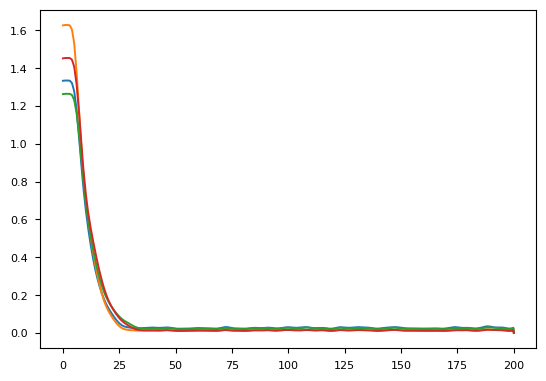

In [33]:
ts = jnp.linspace(0.0, 200.0, 1024)

clip_eval_control = build_control(clip_opt_control, constraint_chain)[0]
cont_eval_control = build_control(cont_opt_control, constraint_chain)[0]

clip_solution = clip_environment.integrate(
    clip_eval_control, clip_environment.init(), None, saveat=diffrax.SaveAt(ts=ts)
)
cont_solution = cont_environment.integrate(
    cont_eval_control, cont_environment.init(), None, saveat=diffrax.SaveAt(ts=ts)
)

clip_cs = jax.vmap(clip_eval_control)(ts)
cont_cs = jax.vmap(cont_eval_control)(ts)

plt.figure()
#plt.plot(ts, clip_solution.ys)
plt.plot(ts, clip_cs)
plt.plot(ts, cont_cs)
plt.show()

# 2D grid of constant drug integrals with implicit control

In [ ]:
key = jax.random.PRNGKey(1234)

environment: FibrosisEnvironment = FibrosisEnvironment()
environment_state = environment.init()

solver = solvers.DirectSolver(optimizer=optax.adam(learning_rate=3e-4))

key, subkey = jax.random.split(key)
control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="linear",
    curve_steps=201,
)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]

In [ ]:
@eqx.filter_jit
def optimize_with_integral(
    target_integral: Array,
) -> Tuple[Scalar, controls.AbstractControl]:
    constraint_chain = constraints.ConstraintChain(
        transformations=[
            constraints.NonNegativeConstantIntegralConstraint(target=target_integral)
        ]
    )

    optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
        num_train_steps=256,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=constraint_chain,
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
        integrate_kwargs=dict(
            dt0=0.01,
            max_steps=1000,
            throw=False,
            stepsize_controller=diffrax.PIDController(
                rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
            ),
        ),
    )

    return optimized_reward, optimized_control

## Even sampling

### Sample

In [ ]:
# Fill for loading

pdgf_integral = jnp.geomspace(1e-3, 1e0, num=10)
csf_integral = jnp.geomspace(1e-3, 1e0, num=10)

pdgf_integral, csf_integral = jnp.meshgrid(pdgf_integral, csf_integral)

target_integrals = []
optimized_rewards = []
optimized_controls = []
for pdgf, csf in tq(zip(pdgf_integral.flatten(), csf_integral.flatten())):
    target_integral = jnp.stack((pdgf, csf))
    target_integrals.append(target_integral)
    optimized_rewards.append(jnp.nan)
    optimized_controls.append(control)

In [ ]:
pdgf_integral = jnp.geomspace(1e-3, 1e0, num=10)
csf_integral = jnp.geomspace(1e-3, 1e0, num=10)

pdgf_integral, csf_integral = jnp.meshgrid(pdgf_integral, csf_integral)

target_integrals = []
optimized_rewards = []
optimized_controls = []
for pdgf, csf in tq(zip(pdgf_integral.flatten(), csf_integral.flatten())):
    target_integral = jnp.stack((pdgf, csf))
    try:
        optimized_reward, optimized_control = optimize_with_integral(target_integral)
    except ValueError:
        target_integrals.append(target_integral)
        optimized_rewards.append(jnp.nan)
        optimized_controls.append(control)
    else:
        target_integrals.append(target_integral)
        optimized_rewards.append(optimized_reward)
        optimized_controls.append(optimized_control)

In [ ]:
@eqx.filter_jit
def evaluate_control(
    control: controls.AbstractControl, target_integral: Array
) -> controls.AbstractControl:
    return build_control(
        control,
        constraints.ConstraintChain(
            transformations=[
                constraints.NonNegativeConstantIntegralConstraint(
                    target=target_integral
                )
            ]
        ),
    )[0]


@eqx.filter_jit
def evaluate_trajectory(
    control: controls.AbstractControl, target_integral: Array
) -> diffrax.Solution:
    return environment.integrate(
        evaluate_control(control, target_integral),
        environment_state,
        None,
        saveat=diffrax.SaveAt(dense=True),
        max_steps=1000,
        throw=False,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
    )

### Save & Load

In [ ]:
with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/target_integrals.eqx", mode="wb"
) as f:
    eqx.tree_serialise_leaves(f, target_integrals)

with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/optimized_rewards.eqx", mode="wb"
) as f:
    eqx.tree_serialise_leaves(f, optimized_rewards)

with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/optimized_controls.eqx", mode="wb"
) as f:
    eqx.tree_serialise_leaves(f, optimized_controls)

In [ ]:
with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/target_integrals.eqx", mode="rb"
) as f:
    target_integrals = eqx.tree_deserialise_leaves(f, target_integrals)

with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/optimized_rewards.eqx", mode="rb"
) as f:
    optimized_rewards = eqx.tree_deserialise_leaves(f, optimized_rewards)

with open(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/optimized_controls.eqx", mode="rb"
) as f:
    optimized_controls = eqx.tree_deserialise_leaves(f, optimized_controls)

### Plot

In [ ]:
def make_grid_plot(n: int, figsize: Tuple[float]):
    # Make grid of plots
    fig, ax_grid = plt.subplots(
        n + 1,
        n + 1,
        figsize=figsize,
        gridspec_kw=dict(
            width_ratios=[0.0] + [1.0] * n, height_ratios=[1.0] * n + [0.0]
        ),
    )

    # Get gridspec
    gs = ax_grid[0, 0].get_gridspec()

    # Remove left row
    for ax in ax_grid[:, 0]:
        ax.remove()

    # Remove bottom row
    for ax in ax_grid[-1, 1:]:
        ax.remove()

    # Add rows back as single large axis
    left_ax = fig.add_subplot(gs[:-1, 0])
    bottom_ax = fig.add_subplot(gs[-1, 1:])

    # Remove extra axes
    left_ax.spines[["right", "top", "bottom"]].set_visible(False)
    left_ax.tick_params(axis="x", bottom=False, labelbottom=False)

    bottom_ax.spines[["right", "left", "top"]].set_visible(False)
    bottom_ax.tick_params(axis="y", left=False, labelleft=False)

    # Modify main grid
    main_ax = ax_grid[:-1, 1:]
    main_ax = np.flip(main_ax, axis=0)
    base_ax = main_ax[0, 0]

    for ax in main_ax.flatten():
        if ax != base_ax:
            # Share axes
            ax.sharex(base_ax)
            ax.sharey(base_ax)

        # Remove ticks
        ax.tick_params(
            axis="both", left=False, labelleft=False, bottom=False, labelbottom=False
        )

    # Unshare axes (deprecated)
    """
    def unshare_axis(grouping, axis):
        for sibling in grouping.get_siblings(axis):
            grouping.remove(sibling)

    def unshare_all(axis):
        unshare_axis(axis.get_shared_x_axes(), axis)
        unshare_axis(axis.get_shared_y_axes(), axis)

    unshare_all(left_ax)
    unshare_all(bottom_ax)
    """

    return fig, main_ax, left_ax, bottom_ax

In [ ]:
# Load the seperatrix

import scipy.io

seperatrix_array = scipy.io.loadmat("../data/Separatrix_array_F06_M07.mat")

In [ ]:
x = np.logspace(
    seperatrix_array["lims_F"][0, 0],
    seperatrix_array["lims_F"][0, 1],
    seperatrix_array["tsteps"][0, 0],
)
y = np.logspace(
    seperatrix_array["lims_M"][0, 0],
    seperatrix_array["lims_M"][0, 1],
    seperatrix_array["tsteps"][0, 0],
)

plt.figure(figsize=(5, 5))
plt.xlabel("F")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.pcolormesh(x, y, 1 - seperatrix_array["S"], cmap="Greys", vmin=0.0, vmax=3.0)
plt.show()

In [ ]:
# System Trajectories

ts = jnp.linspace(0.0, 200.0, 201)

fig, main_ax, left_ax, bottom_ax = make_grid_plot(
    10, figsize=(plot_half_width, plot_half_width)
)

left_ax.set_ylabel("anti-CSF")
bottom_ax.set_xlabel("anti-PDGF")

left_ax.set_yscale("log")
left_ax.set_ylim([1e-3, 1e0])

bottom_ax.set_xscale("log")
bottom_ax.set_xlim([1e-3, 1e0])

# main_ax[0, 0].set_xscale("log")
# main_ax[0, 0].set_yscale("log")
# main_ax[0, 0].set_xlim([1e0, 1e6])
# main_ax[0, 0].set_ylim([1e0, 1e7])

main_ax[0, 0].set_xlim([0, 6])
main_ax[0, 0].set_ylim([0, 7])

main_ax[0, 0].set_xlabel("F")
main_ax[0, 0].set_ylabel("M")

ax = main_ax.flatten()

for i in range(100):
    try:
        if jnp.isnan(optimized_rewards[i]):
            raise ValueError

        sol = evaluate_trajectory(optimized_controls[i], target_integrals[i])
        ys = jax.vmap(sol.evaluate)(ts)
        ys = jnp.log10(ys[..., :2])

        if jnp.any(jnp.isnan(ys)):
            raise ValueError

    except (ValueError, AttributeError):
        ax[i].set_facecolor("red")
    else:
        # ax[i].pcolormesh(
        #    x, y, 1 - seperatrix_array["S"], cmap="Greys", vmin=0.0, vmax=3.0
        # )
        ax[i].contourf(
            1 - seperatrix_array["S"],
            cmap="Greys",
            vmin=0.0,
            vmax=3.0,
            extent=(0, 6, 7, 0),
            origin="upper",
            levels=1,
        )
        ax[i].plot(ys[..., 0], ys[..., 1])
    finally:
        ax[i].tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

plt.savefig(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/system_trajectory_grid.png",
    bbox_inches="tight",
)
plt.savefig(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/system_trajectory_grid.svg",
    bbox_inches="tight",
)
plt.show()

In [ ]:
# Control Trajectories

ts = jnp.linspace(0.0, 200.0, 201)

fig, main_ax, left_ax, bottom_ax = make_grid_plot(
    10, figsize=(plot_half_width, plot_half_width)
)

left_ax.set_ylabel("anti-CSF")
bottom_ax.set_xlabel("anti-PDGF")

left_ax.set_yscale("log")
left_ax.set_ylim([1e-3, 1e0])

bottom_ax.set_xscale("log")
bottom_ax.set_xlim([1e-3, 1e0])

main_ax[0, 0].set_xlabel("C")
main_ax[0, 0].set_ylabel("T")

ax = main_ax.flatten()

for i in range(100):
    try:
        if jnp.isnan(optimized_rewards[i]):
            raise ValueError

        sol = evaluate_trajectory(optimized_controls[i], target_integrals[i])
        ys = jax.vmap(sol.evaluate)(ts)
        ys = jnp.log10(ys[..., :2])

        if jnp.any(jnp.isnan(ys)):
            raise ValueError

        constrained_control = build_control(
            optimized_controls[i],
            constraints.ConstraintChain(
                transformations=[
                    constraints.NonNegativeConstantIntegralConstraint(
                        target=jnp.ones(2)
                    )
                ]
            ),
        )[0]

        cs = jax.vmap(constrained_control)(ts.reshape(-1, 1))

    except (ValueError, AttributeError):
        ax[i].set_facecolor("red")
    else:
        ax[i].plot(ts, cs[..., 0])
        ax[i].plot(ts, cs[..., 1])
    finally:
        ax[i].tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

plt.savefig(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/control_trajectory_grid.png",
    bbox_inches="tight",
)
plt.savefig(
    result_base_dir + "/2d_grid_201steps_3e-4lr_dtmax/control_trajectory_grid.svg",
    bbox_inches="tight",
)
plt.show()

## Adaptive sampling

### Optimized control

In [ ]:
import time

from adaptive import Learner2D, notebook_extension
from IPython.display import clear_output

notebook_extension()


@eqx.filter_jit
def final_evaluate_with_integral(
    integral: Array, control: controls.AbstractControl
) -> Tuple[Scalar, controls.AbstractControl]:
    constrained_control = build_control(
        control,
        constraints.ConstraintChain(
            transformations=[
                constraints.NonNegativeConstantIntegralConstraint(target=integral)
            ]
        ),
    )[0]

    solution = environment.integrate(
        constrained_control,
        environment_state,
        None,
        max_steps=10000,
        throw=True,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
        dt0=0.01,
    )

    reward = reward_fn(solution)
    return reward


constant_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
constant_learner.stack_size = 1

plot_timer = time.time()
plot_interval = 15
adaptive_results = []
while True:
    points, _ = constant_learner.ask(1)
    point = points[0]

    integral = jnp.asarray(point, dtype=jnp.float64)
    integral = 10**integral

    # Optimize
    failed_optimization = True
    try:
        adaptive_reward, adaptive_control = optimize_with_integral(integral)
    except ValueError:
        adaptive_reward = jnp.nan
        adaptive_control = control
    except KeyboardInterrupt:
        break
    else:
        failed_optimization = False

    # Evaluate final control with higher max_steps, but error when too many steps
    # are taken
    failed_evaluation = True
    if not failed_optimization:
        try:
            adaptive_reward = final_evaluate_with_integral(integral, adaptive_control)
        except ValueError:
            adaptive_reward = jnp.nan
        except KeyboardInterrupt:
            break
        else:
            failed_evaluation = False

    constant_learner.tell(point, float(adaptive_reward))
    adaptive_results.append(
        {
            "point": point,
            "integral": integral,
            "reward": adaptive_reward,
            "control": adaptive_control,
            "failed_optimization": failed_optimization,
            "failed_evaluation": failed_evaluation,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(constant_learner.plot(tri_alpha=0.25))

In [ ]:
import base64
import io
import json
from typing import Any
import dataclasses


class JaxSONEncoder(json.JSONEncoder):
    def default(self, o: Any) -> Any:
        if dataclasses.is_dataclass(o):
            return {
                "__dataclass__": True,
                "__class_name__": o.__class__.__module__
                + "."
                + o.__class__.__qualname__,
                "fields": dataclasses.asdict(o),
            }

        if isinstance(o, Array):
            # Convert to numpy array
            o = np.asarray(o)

            # Save to memory
            buffer = io.BytesIO()
            jnp.save(buffer, o, allow_pickle=False)

            # Convert the numpy array to a base64 encoded string
            data = base64.b64encode(buffer.getvalue()).decode("utf-8")

            # Include type annotation and return data
            return {"__numpy_array__": True, "data": data}

        # For other types, use the default encoder
        return super().default(o)


class JaxSONDecoder(json.JSONDecoder):
    def __init__(self, dataclass_lookup: dict[str, Any], *args, **kwargs):
        super().__init__(object_hook=self.object_hook, *args, **kwargs)

        self.dataclass_lookup = dataclass_lookup

    def object_hook(self, o: Any) -> Any:
        if "__dataclass__" in o:
            # Construct class instance with __new__
            # This allows us to avoid calling __init__, which might be overridden
            dataclass_class = self.dataclass_lookup[o["__class_name__"]]
            dataclass_instance = dataclass_class.__new__(dataclass_class)

            # Replace currently undefined fields with saved fields
            dataclass_instance = dataclasses.replace(dataclass_instance, **o["fields"])
            return dataclass_instance

            # eqx.tree_at(lambda pytree: jax.tree_util.tree_flatten(pytree)[0], dataclass_instance, )

        if "__numpy_array__" in o:
            # Decode the base64 encoded data
            data = base64.b64decode(o["data"])

            # Load the numpy array
            buffer = io.BytesIO(data)
            return jnp.load(buffer)

        return o


jax_json_encoder = JaxSONEncoder(indent=4)
json_string = jax_json_encoder.encode(
    nn.InterpolationCurve(t_start=0.0, t_end=1.0, steps=64, channels=2)
    # eqx.nn.Linear(1, 2, key=jax.random.PRNGKey(1234))
)

print(json_string)

jax_json_decoder = JaxSONDecoder(
    dataclass_lookup={
        "optimal_control.nn.InterpolationCurve": nn.InterpolationCurve,
        "equinox.nn._linear.Linear": eqx.nn.Linear,
    }
)
jax_json_decoder.decode(json_string)

In [ ]:
constant_learner.save(result_base_dir + "/2d_adaptive/learner.pickle")
eqx.tree_serialise_leaves(
    result_base_dir + "/2d_adaptive/results.eqx", adaptive_results
)

with open(result_base_dir + "/2d_adaptive/results.jxson", mode="w") as f:
    json.dump(adaptive_results, f, cls=JaxSONEncoder)

In [ ]:
from adaptive import Learner2D, notebook_extension

notebook_extension()

constant_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
constant_learner.stack_size = 1

constant_learner.load(result_base_dir + "/2d_adaptive/learner.pickle")

# with open(result_base_dir + "/2d_adaptive/results.jxson", mode="r") as f:
#    adaptive_results = json.load(f, cls=JaxSONDecoder, dataclass_lookup={"optimal_control.nn.InterpolationCurve": nn.InterpolationCurve, "optimal_control.nn.": controls.})

In [ ]:
# Plot

pdgf, csf, reward = constant_learner.interpolated_on_grid()

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.imshow(
    reward.T,
    cmap="inferno",
    extent=(pdgf[0], pdgf[-1], csf[0], csf[-1]),
    origin="lower",
)
plt.xlabel("log10 anti-PDGF")
plt.ylabel("log10 anti-CSF")
plt.colorbar(fraction=0.04575, pad=0.04, label="Reward")
plt.savefig(
    result_base_dir + "/2d_adaptive/optimized_adaptive_grid.png", bbox_inches="tight"
)
plt.savefig(
    result_base_dir + "/2d_adaptive/optimized_adaptive_grid.svg", bbox_inches="tight"
)
plt.show()

### Constant control

In [ ]:
import time

from adaptive import Learner2D, notebook_extension
from IPython.display import clear_output

notebook_extension()


@eqx.filter_jit
def evaluate_with_integral(integral: Array) -> Tuple[Scalar, controls.AbstractControl]:
    constant_control = controls.LambdaControl(lambda _, c: c, data=integral)

    solution = environment.integrate(
        constant_control,
        environment_state,
        None,
        max_steps=10000,
        throw=True,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
        dt0=0.01,
    )

    reward = reward_fn(solution)
    return reward


constant_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
constant_learner.stack_size = 1

plot_timer = time.time()
plot_interval = 15
adaptive_results = []
while True:
    points, _ = constant_learner.ask(1)
    point = points[0]

    integral = jnp.asarray(point, dtype=jnp.float64)
    integral = 10**integral

    # Evaluate
    failed_evaluation = True
    try:
        adaptive_reward = evaluate_with_integral(integral)
    except ValueError:
        adaptive_reward = jnp.nan
    except KeyboardInterrupt:
        break
    else:
        failed_evaluation = False

    constant_learner.tell(point, float(adaptive_reward))
    adaptive_results.append(
        {
            "point": point,
            "integral": integral,
            "reward": adaptive_reward,
            "failed_evaluation": failed_evaluation,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(constant_learner.plot(tri_alpha=0.25))

In [ ]:
constant_learner.save(result_base_dir + "/2d_adaptive/constant_learner.pickle")

In [ ]:
# Load

from adaptive import Learner2D, notebook_extension

notebook_extension()

constant_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
constant_learner.stack_size = 1

constant_learner.load(result_base_dir + "/2d_adaptive/constant_learner.pickle")

# Plot

pdgf, csf, reward = constant_learner.interpolated_on_grid()

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.imshow(
    reward.T,
    cmap="inferno",
    extent=(pdgf[0], pdgf[-1], csf[0], csf[-1]),
    origin="lower",
)
plt.xlabel("log10 anti-PDGF")
plt.ylabel("log10 anti-CSF")
plt.colorbar(fraction=0.04575, pad=0.04, label="Reward")
plt.savefig(
    result_base_dir + "/2d_adaptive/constant_adaptive_grid.png", bbox_inches="tight"
)
plt.savefig(
    result_base_dir + "/2d_adaptive/constant_adaptive_grid.svg", bbox_inches="tight"
)
plt.show()

### Difference

In [ ]:
# Load

from adaptive import Learner2D, notebook_extension
from resize_right import resize, interp_methods

notebook_extension()

constant_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
constant_learner.stack_size = 1

constant_learner.load(result_base_dir + "/2d_adaptive/constant_learner.pickle")

optimal_learner = Learner2D(lambda x: 0, bounds=[(-6, 0), (-3, 3)])
optimal_learner.stack_size = 1

optimal_learner.load(result_base_dir + "/2d_adaptive/learner.pickle")

# Plot

pdgf, csf, constant_reward = constant_learner.interpolated_on_grid()
pdgf, csf, optimal_reward = optimal_learner.interpolated_on_grid()

difference_reward = optimal_reward - resize(
    constant_reward,
    out_shape=optimal_reward.shape,
    interp_method=interp_methods.linear,
    pad_mode="edge",
)

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.imshow(
    difference_reward.T,
    cmap="inferno",
    extent=(pdgf[0], pdgf[-1], csf[0], csf[-1]),
    origin="lower",
)
plt.xlabel("log10 anti-PDGF")
plt.ylabel("log10 anti-CSF")
plt.colorbar(fraction=0.04575, pad=0.04, label="Advantage")
plt.savefig(
    result_base_dir + "/2d_adaptive/difference_adaptive_grid.png", bbox_inches="tight"
)
plt.savefig(
    result_base_dir + "/2d_adaptive/difference_adaptive_grid.svg", bbox_inches="tight"
)
plt.show()

# 1D line of constant sum drug integrals with implicit control

In [ ]:
key = jax.random.PRNGKey(1234)

environment: FibrosisEnvironment = FibrosisEnvironment()
environment_state = environment.init()

solver = solvers.DirectSolver(optimizer=optax.adam(learning_rate=3e-4))

key, subkey = jax.random.split(key)
control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=200.0,
    to_curve=True,
    curve_interpolation="linear",
    curve_steps=201,
)


def reward_fn(solution: diffrax.Solution) -> Scalar:
    return solution.ys[-1, -1]

In [ ]:
@eqx.filter_jit
def optimize_with_integral(
    target_integral: Array,
) -> Tuple[Scalar, controls.AbstractControl]:
    constraint_chain = constraints.ConstraintChain(
        transformations=[
            constraints.NonNegativeConstantIntegralConstraint(
                target=target_integral, constrain_sum=True
            )
        ]
    )

    optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
        num_train_steps=256,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=constraint_chain,
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
        integrate_kwargs=dict(
            dt0=0.01,
            max_steps=1000,
            throw=False,
            stepsize_controller=diffrax.PIDController(
                rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
            ),
        ),
    )

    return optimized_reward, optimized_control

## Optimized control

In [ ]:
import time

from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output

notebook_extension()


@eqx.filter_jit
def final_evaluate_with_integral(
    integral: Array, control: controls.AbstractControl
) -> Tuple[Scalar, controls.AbstractControl]:
    constrained_control = build_control(
        control,
        constraints.ConstraintChain(
            transformations=[
                constraints.NonNegativeConstantIntegralConstraint(
                    target=integral, constrain_sum=True
                )
            ]
        ),
    )[0]

    solution = environment.integrate(
        constrained_control,
        environment_state,
        None,
        max_steps=10000,
        throw=True,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
        dt0=0.01,
    )

    reward = reward_fn(solution)
    return reward


constant_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
constant_learner.stack_size = 1

start_time = time.time()
max_time = 15 * 60

plot_timer = time.time()
plot_interval = 15
adaptive_results = []
while time.time() - start_time < max_time:
    points, _ = constant_learner.ask(1)
    point = points[0]

    integral = jnp.asarray([point], dtype=jnp.float64)
    integral = 10**integral

    # Optimize
    failed_optimization = True
    try:
        adaptive_reward, adaptive_control = optimize_with_integral(integral)
    except ValueError:
        adaptive_reward = jnp.nan
        adaptive_control = control
    except KeyboardInterrupt:
        break
    else:
        failed_optimization = False

    # Evaluate final control with higher max_steps, but error when too many steps
    # are taken
    failed_evaluation = True
    if not failed_optimization:
        try:
            adaptive_reward = final_evaluate_with_integral(integral, adaptive_control)
        except ValueError:
            adaptive_reward = jnp.nan
        except KeyboardInterrupt:
            break
        else:
            failed_evaluation = False

    constant_learner.tell(point, float(adaptive_reward))
    adaptive_results.append(
        {
            "point": point,
            "integral": integral,
            "reward": adaptive_reward,
            "control": adaptive_control,
            "failed_optimization": failed_optimization,
            "failed_evaluation": failed_evaluation,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(constant_learner.plot())

In [ ]:
# Save

constant_learner.save(result_base_dir + "/1d_adaptive/optimal_learner.pickle")

In [ ]:
# Load

import time

from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output

notebook_extension()

optimal_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
optimal_learner.stack_size = 1

optimal_learner.load(result_base_dir + "/1d_adaptive/optimal_learner.pickle")

# Plot

points = optimal_learner.to_numpy()
argsort = np.argsort(points[..., 0])
points = points[argsort]

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.xlabel("log10(PDGF + CSFG)")
plt.ylabel("Reward")
plt.plot(*points.T)
plt.xlim([-3, 1])
plt.savefig(
    result_base_dir + "/1d_adaptive/optimal_adaptive_interval.png", bbox_inches="tight"
)
plt.savefig(
    result_base_dir + "/1d_adaptive/optimal_adaptive_interval.svg", bbox_inches="tight"
)
plt.show()

## Constant control

In [ ]:
import time

from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output

notebook_extension()


@eqx.filter_jit
def evaluate_with_integral(integral: Array) -> Tuple[Scalar, controls.AbstractControl]:
    constant_control = controls.LambdaControl(
        lambda _, c: c, data=jnp.repeat(integral, 2) / 2
    )

    solution = environment.integrate(
        constant_control,
        environment_state,
        None,
        max_steps=10000,
        throw=True,
        stepsize_controller=diffrax.PIDController(
            rtol=1e-4, atol=1e-4, pcoeff=1.0, icoeff=1.0, dtmax=1.0
        ),
        dt0=0.01,
    )

    reward = reward_fn(solution)
    return reward


evaluate_with_integral(jnp.asarray([1.0]))  # Force compile

constant_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
constant_learner.stack_size = 1

start_time = time.time()
max_time = 15

plot_timer = time.time()
plot_interval = 15
adaptive_results = []
while time.time() - start_time < max_time:
    points, _ = constant_learner.ask(1)
    point = points[0]

    integral = jnp.asarray([point], dtype=jnp.float64)
    integral = 10**integral

    # Evaluate
    failed_evaluation = True
    if not failed_optimization:
        try:
            adaptive_reward = evaluate_with_integral(integral)
        except ValueError:
            adaptive_reward = jnp.nan
        except KeyboardInterrupt:
            break
        else:
            failed_evaluation = False

    constant_learner.tell(point, float(adaptive_reward))
    adaptive_results.append(
        {
            "point": point,
            "integral": integral,
            "reward": adaptive_reward,
            "failed_evaluation": failed_evaluation,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(constant_learner.plot())

In [ ]:
# Save

constant_learner.save(result_base_dir + "/1d_adaptive/constant_learner.pickle")

In [ ]:
# Load

from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output

notebook_extension()

constant_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
constant_learner.stack_size = 1

constant_learner.load(result_base_dir + "/1d_adaptive/constant_learner.pickle")

# Plot

points = constant_learner.to_numpy()
argsort = np.argsort(points[..., 0])
points = points[argsort]

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.xlabel("log10(PDGF + CSFG)")
plt.ylabel("Reward")
plt.plot(*points.T)
plt.xlim([-3, 1])
plt.savefig(
    result_base_dir + "/1d_adaptive/constant_adaptive_interval.png", bbox_inches="tight"
)
plt.savefig(
    result_base_dir + "/1d_adaptive/constant_adaptive_interval.svg", bbox_inches="tight"
)
plt.show()

## Difference

In [ ]:
# Load

from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output

notebook_extension()

constant_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
constant_learner.stack_size = 1

constant_learner.load(result_base_dir + "/1d_adaptive/constant_learner.pickle")

optimal_learner = Learner1D(lambda x: 0, bounds=(-6, 6))
optimal_learner.stack_size = 1

optimal_learner.load(result_base_dir + "/1d_adaptive/optimal_learner.pickle")

# Plot

constant_points = constant_learner.to_numpy()
optimal_points = optimal_learner.to_numpy()

x = np.linspace(-3, 1, 256)
points = np.interp(x, optimal_points[..., 0], optimal_points[..., 1]) - np.interp(
    x, constant_points[..., 0], constant_points[..., 1]
)

plt.figure(
    figsize=(plot_half_width * plot_shrink_factor, plot_half_width * plot_shrink_factor)
)
plt.xlabel("log10(PDGF + CSFG)")
plt.ylabel("Advantage")
plt.plot(x, points)
plt.xlim([-3, 1])
plt.savefig(
    result_base_dir + "/1d_adaptive/difference_adaptive_interval.png",
    bbox_inches="tight",
)
plt.savefig(
    result_base_dir + "/1d_adaptive/difference_adaptive_interval.svg",
    bbox_inches="tight",
)
plt.show()